this notebook reproduces figures from the https://doi.org/10.3390/rs13061098
# NOT MEANT FOR S3_loader testing or demo

# The code below implies that all files from DANS archive were downloaded and unzipped to DANS folder
https://doi.org/10.17026/dans-xb8-efke

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from xarray import open_dataset
import numpy as np
from geopy.distance import distance
import sqlite3

In [3]:
dans_path = Path('.', 'DANS', 'original')
assert dans_path.is_dir(), 'please, download https://doi.org/10.17026/dans-xb8-efke and unzip to the folder named DANS located in the folder with notebook'

# Functions

In [4]:
def join_extraction(extr_dir):
    names = [x.name.replace('_productIdMap.txt', '') for x in Path(extr_dir).glob('*_productIdMap.txt')]  # a trick to get names
    df_all = pd.DataFrame()
    n_todo = len(names)
    for i, name in enumerate(names):
        if i % 10 == 0:
            print(f'{i} / {n_todo}')
        df_pix = pd.read_csv(Path(extr_dir, f'{name}_OL_1_EFR_measurements.txt'), comment='#', sep='\t', index_col='ProdID')
        df_prod = pd.read_csv(Path(extr_dir, f'{name}_productIdMap.txt'), comment='#', sep='\t', index_col='ProductID')
#         if df_pix.shape[0] != df_prod.shape[0]:
#             print('n rows mismatch: less names than products?!')
        
        df_joined = df_prod.join(df_pix)
        if df_pix.shape[0] != df_joined.shape[0]:
            print(f'expected {df_pix.shape[0]}, resulted {df_joined.shape[0]}')
        
        df_joined['name'] = df_joined.ProductLocation.apply(lambda x: Path(x).parent.name.replace('.SEN3', ''))
        
        df_joined['m_to_tower_tp'] = df_joined.apply(lambda row: get_distance(row.TP_latitude, row.TP_longitude), axis=1)
        df_joined['m_to_tower_geo'] = df_joined.apply(lambda row: get_distance(row.latitude, row.longitude), axis=1)
        df_joined['m_to_tower_extraction'] = df_joined.apply(lambda row: get_distance(row.Latitude, row.Longitude), axis=1)
        
        df_all = df_all.append(df_joined)
#     df_all = add_flags(df_all)
    df_all = drop_not_sql(df_all)
    df_all['gee_name'] = df_all.name.str[:47].str.replace('OL_1_EFR____', '')
    df_all.index = pd.to_datetime(df_all['Date(yyyy-MM-dd)'] + ' ' + df_all['Time(HH_mm_ss)'])
    df_all.index.name = 'dt'
    return df_all

db_path = dans_path / 'NL_Spe_olci.db'
def drop_not_sql(df, db_path=db_path):
    df_db = pd.read_sql('SELECT * FROM OL_1_EFR___', sqlite3.connect(db_path))
    return df[df.name.isin(df_db.name)]

# adds original qulaity flag
# qc_single_csv = r"D:\PyCharm_projects\Spe\gee\quality_flags_geo.csv"
# def add_flags(df, qc_singe_csv=qc_single_csv):
#     # single band quality_flags is exported wrongly, but single bands are there
#     df_geo = pd.read_csv(qc_single_csv, index_col='name')
#     qc = df_geo.qc.str.strip('[]').astype(np.uint32)
#     df = df.set_index('name')
#     df = df.join(qc)
#     return df.reset_index()

def get_distance(m_lat, m_lon, lat=52.251185, lon=5.690051):
    if np.isnan(m_lat):
        return np.nan
    return distance((lat, lon), (m_lat, m_lon)).meters


def satvap(T):
    if np.all(T > 200):
        T = T - 273.15
    a = 7.5
    b = 237.3
    es = 6.107*10 ** (7.5 *T /(b + T))
    return es

def abline(slope, intercept, ax):
    """
    Plot a line from slope and intercept
    https://stackoverflow.com/a/43811762 modified from David Marx
    """
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, 'k--')

In [5]:
# code for GEE file processing [optional]

def read_gee(gee_path):
    gee = pd.read_csv(gee_path)
    DUPLICATED_MASK = 8388608
    gee['quality_flags_duplicated'] = gee.quality_flags.map(lambda x: int(bool(DUPLICATED_MASK & int(x))) if not np.isnan(x) else np.nan)
#     gee = decode_flags(gee)
    gee.index = pd.to_datetime(gee['system:index'].str[4:19])
    gee.index.name = 'dt'
    gee['name'] = gee.product_id
    gee['m_to_tower_geo'] = gee.apply(lambda row: get_distance(row.latitude, row.longitude), axis=1)
    gee['width'] = gee.x_max - gee.x_min  # 45 -(-1)
    gee['height'] = gee.y_max - gee.y_min
    gee['x_cor'] = gee.x - gee.x_min 
    gee['y_cor'] = gee.y - gee.y_min 
    return gee

# for all quality quality flag decoding an original OLCI level-1 image should be available
# olci_image_path = r"D:\PyCharm_projects\Spe\subset\olci\S3A_OL_1_EFR____20190101T093149_20190101T093449_20190102T140758_0179_039_364_2160_LN1_O_NT_002.nc"

# def decode_flags(df_gee, olci_path=olci_image_path):
#     nc = open_dataset(olci_path)
#     df_flags_gee = df_gee.quality_flags.map(lambda x: (nc.quality_flags.flag_masks & int(x)).astype(bool).astype(int) if not np.isnan(x) else [np.nan])
#     qc_names = [f'quality_flags_{x}' for x in nc.quality_flags.flag_meanings.split()]
#     nc.close()
#     df_flags_gee = pd.DataFrame(df_flags_gee.tolist(), columns=qc_names, index=df_flags_gee.index)
#     return df_gee.join(df_flags_gee)

In [6]:
def get_central(g, dist_col='m_to_tower_geo'):
    min_dist = g[dist_col].min()
    if min_dist < 400:
        return g.iloc[g[dist_col].argmin()]

# Meteorological data figures

Meteorological data was taken for January 2020. This part can be reproduced without DANS files, because it is only one month (55 images) of data

In the `S3_loader` package `example.py` 
1. set `period = ('2020-01-01', '2020-01-31')` (Line 31) to start the download
2. uncomment L62, L64, L65 to extract the pixel time series with SNAP gpt tool
3. once downloaded and extracted provide the path below

In [7]:
# extracted_dir_path = r'example_extracted'
df3x3 = join_extraction(dans_path / 'olci_extracted_3x3')
df = df3x3.groupby(df3x3.index).apply(get_central).dropna()  # needed only for DANS
df.shape

0 / 25
10 / 25
20 / 25


(1909, 174)

In [9]:
df.head()

,ProductType,ProductLocation,CoordID,Name,Latitude,Longitude,PixelX,PixelY,Date(yyyy-MM-dd),Time(HH_mm_ss),...,quality_flags_saturated_Oa17,quality_flags_saturated_Oa18,quality_flags_saturated_Oa19,quality_flags_saturated_Oa20,quality_flags_saturated_Oa21,name,m_to_tower_tp,m_to_tower_geo,m_to_tower_extraction,gee_name
dt,,,,,,,,,,,,,,,,,,,,,
2016-04-26 09:39:07,OL_1_EFR,/home/prikaziuke/spe_loader/full/olci/S3A_OL_1...,1.0,test_3_2,52.252006,5.687398,938.5,4004.5,2016-04-26,09:39:07,...,0.0,0.0,0.0,0.0,0.0,S3A_OL_1_EFR____20160426T093611_20160426T09391...,397.670658,202.937237,202.908011,S3A_20160426T093611_20160426T093911
2016-04-28 10:27:17,OL_1_EFR,/home/prikaziuke/spe_loader/full/olci/S3A_OL_1...,1.0,test_0_1,52.250128,5.690462,3935.5,3386.5,2016-04-28,10:27:17,...,0.0,0.0,0.0,0.0,0.0,S3A_OL_1_EFR____20160428T102448_20160428T10274...,317.832117,120.735377,120.917548,S3A_20160428T102448_20160428T102748
2016-04-29 10:01:23,OL_1_EFR,/home/prikaziuke/spe_loader/full/olci/S3A_OL_1...,1.0,test_3_3,52.251874,5.689750,2335.5,3784.5,2016-04-29,10:01:23,...,0.0,0.0,0.0,0.0,0.0,S3A_OL_1_EFR____20160429T095837_20160429T10013...,167.815340,79.265282,79.374439,S3A_20160429T095837_20160429T100137
2016-04-30 09:35:24,OL_1_EFR,/home/prikaziuke/spe_loader/full/olci/S3A_OL_1...,1.0,test_0_2,52.251080,5.692963,706.5,4054.5,2016-04-30,09:35:24,...,0.0,0.0,0.0,0.0,0.0,S3A_OL_1_EFR____20160430T093226_20160430T09352...,188.524618,199.223539,199.212249,S3A_20160430T093226_20160430T093526
2016-05-02 10:23:36,OL_1_EFR,/home/prikaziuke/spe_loader/full/olci/S3A_OL_1...,1.0,test_4_4,52.252177,5.690673,3708.5,3466.5,2016-05-02,10:23:36,...,0.0,0.0,0.0,0.0,0.0,S3A_OL_1_EFR____20160502T102104_20160502T10240...,104.343255,118.393871,118.273136,S3A_20160502T102104_20160502T102404


## Figure 7

### CAMS reading - interpolation

CAMS data is available through Copernicus Atmosphere Data Store (ADS) at **coarser resolution** that was used in the paper 0.75 vs 0.125 arc-degrees
https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-reanalysis-eac4?tab=form

corresponding variable names can be found in Section 2.3.2. Meteo:

Variables at Surface (Single in ADS) level:
- total column water vapor (tcwv, 137)
- total column ozone (gtco3, 210206) from GEMS
- mean sea level pressure (msl, 151)
- 10 meter U and V wind components (horizontal wind vectors u10, v10)

Relative humidity at 850 hPa is not available anymore at Pressure (Multi in ADS) level and has to be calclulated from
- specific humidity (q) @ 850hPa
- temperature (t) @ 850hPa

In [10]:
jan = df.sort_index()['2020-01-01': '2020-01-31']
lat = 52.251185
lon = 5.690051

In [11]:
nc = open_dataset(dans_path / 'meteo' / 'CAMS_2020_jan_1pix.nc')
if 'latitude' in nc.dims:
    nc_int = nc.interp(dict(latitude=lat, longitude=lon, time=jan.index))
else:
    nc_int = nc.interp(dict(time=jan.index))
nc.close()

In [12]:
## humidity @850hPa
nc = open_dataset(dans_path / 'meteo' / '2020_Jan_CAMS_rh_850_1pix.nc')
if 'latitude' in nc.dims:
    nc_h_int = nc.interp(dict(latitude=lat, longitude=lon, time=jan.index))
else:
    nc_h_int = nc.interp(dict(time=jan.index))
nc.close()

if 'r' in nc_h_int.variables:  # old CAMS
    nc_int = nc_int.merge(nc_h_int)
else:
    MH2O = 18
    Mair = 29
    p = 850
    e_to_q      = MH2O/Mair/p  # e = q / e_to_q

    ea = nc_h_int.q / e_to_q
    es = satvap(nc_h_int.t)

    rh = ea / es * 100
    nc_int = nc_int.merge({'r': rh})

In [13]:
pairs = {
    'tcwv': ('total_columnar_water_vapour', r'${\rm kg\ m^{-2}}$'),
    'gtco3': ('total_ozone', r'$\rm kg\ m^{-2}$'),
    'msl': ('sea_level_pressure', r'$\rm hPa$'),
    'u10': ('horizontal_wind_vector_1', r'$\rm m\ s^{-1}$'),
    'v10': ('horizontal_wind_vector_2', r'$\rm m\ s^{-1}$'),
    'r': ('humidity', r'%')  # relative humidity @850hPa
}

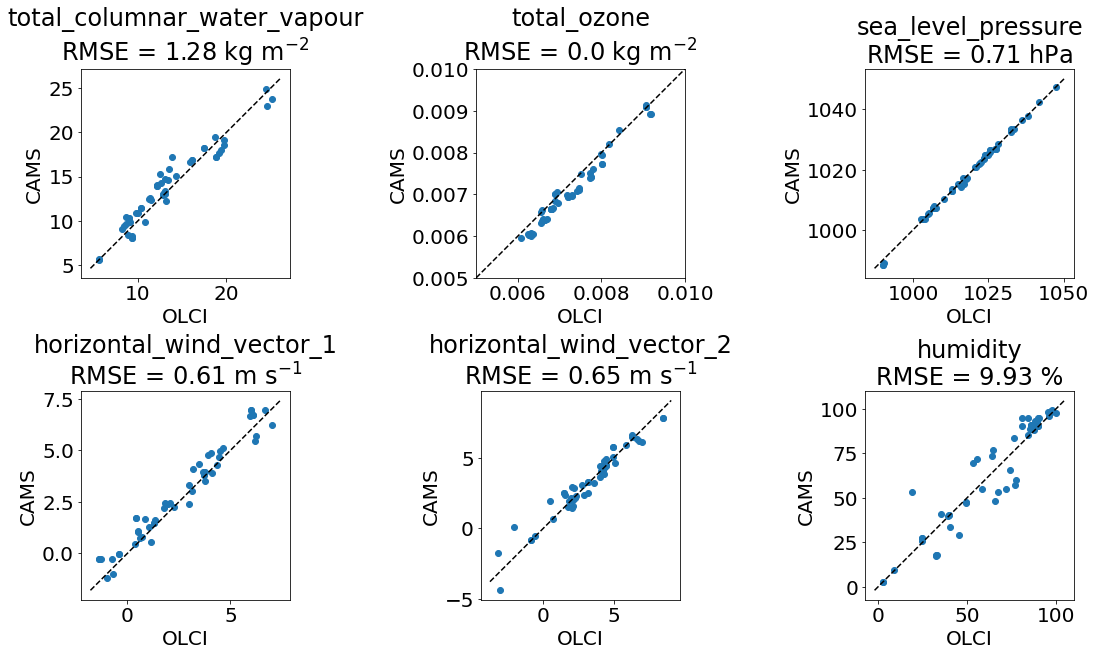

In [14]:
plt.rcParams.update({'font.size': 20})

_, axs = plt.subplots(2, 3, figsize=(16, 9), constrained_layout=True)

axs = axs.flatten()
for i, k in enumerate(pairs):
    ax = axs[i]
    name, units = pairs[k]
    x = jan[name]
    if k not in nc_int:
        continue
    y = nc_int[k].copy()
    if k == 'msl':
        y /= 100
    elif k == 'd2m':
        ta = nc_int['t2m'] - 273.15
        ea = satvap(y - 273.15)
        es = satvap(ta)
        y = ea / es * 100      
    ax.scatter(x, y)
    if k == 'd2m':
        ax.scatter(x, nc_h_int.q * 1e2)
        ax.legend(['relative, %', 'specific, %'])
        ax.set_title(name)
    else:
        rmse = np.sqrt(np.mean((x - y) ** 2))
        ax.set_title(f'{name}\nRMSE = {round(rmse, 2)} {units}')
    
    if k == 'gtco3':
        ax.set_xlim([0.005, 0.010])
        ax.set_ylim([0.005, 0.010])
    ax.set_xlabel('OLCI')
    ax.set_ylabel('CAMS')
    abline(1, 0, ax)
    ax.set_aspect('equal', 'box')
plt.savefig('figures/fig7.png')

## Figure 8

### CAMS reading - interpolation

CAMS data is available through Copernicus Atmosphere Data Store (ADS) at **coarser resolution** that was used in the paper 0.75 vs 0.125 arc-degrees
https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-reanalysis-eac4?tab=form

corresponding variable names can be found in Section 2.3.2. Meteo:

- Temperature at Pressure (Multi in ADS) level (all 25 pressure levels from 1 to 1000 hPa)

In [15]:
jan = df.sort_index()['2020-01-01': '2020-01-31']
lat = 52.251185
lon = 5.690051

In [16]:
cams_pressure_path = r"D:\PyCharm_projects\S3_loader\levtype_pl.nc"
nc_pressure = open_dataset(dans_path / 'meteo' / 'CAMS_2020_jan_CAMS_Ta_profile_1pix.nc')
if 'latitude' in nc.dims:
    nc_p_int = nc_pressure.interp(dict(latitude=lat, longitude=lon, level=nc_pressure.level, time=jan.index))
else:
    nc_p_int = nc_pressure.interp(dict(level=nc_pressure.level, time=jan.index))
nc_pressure.close()

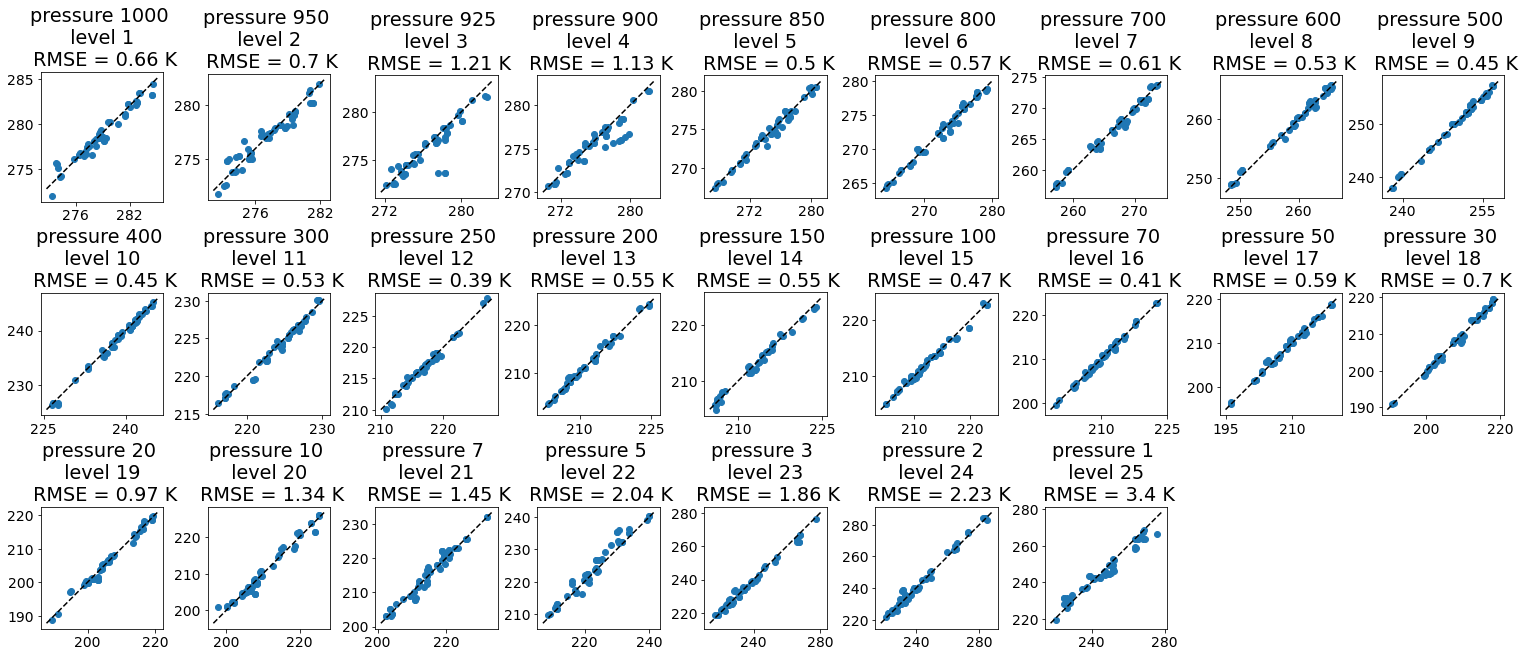

In [18]:
levels = nc_p_int.level.values[::-1]

plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(3, 9, figsize=(21, 9), constrained_layout=True)

axs = axs.flatten()
for i in range(len(levels)):
    ax = axs[i]
    x = jan[f'atmospheric_temperature_profile_pressure_level_{i+1}']
    pressure = levels[i]
    y = nc_p_int.sel(level=pressure).t
    ax.scatter(x, y)
    rmse = np.sqrt(np.mean((x - y) ** 2))
    ax.set_title(f'pressure {pressure} \n level {i+1} \n RMSE = {round(rmse, 2)} K')
    abline(1, 0, ax)
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.tick_params(axis='both', which='major', labelsize=14)
fig.delaxes(axs[i+1])
fig.delaxes(axs[i+2])
plt.savefig('figures/fig8.png')

# Complete dataset figures

## Reading

GEE file from https://code.earthengine.google.com/61fe01512385e06b5bc3f65f78bef692?noload=true

DHUS from ``S3_loader`` for the whole period

In [19]:
df3x3 = join_extraction(dans_path / 'olci_extracted_3x3')
df = df3x3.groupby(df3x3.index).apply(get_central).dropna()

0 / 25
10 / 25
20 / 25


In [20]:
# if from GEE sciprt
# gee = read_gee(r"D:\PyCharm_projects\Spe\gee\s3_spe_300m.csv")
gee = pd.read_csv(dans_path / 'gee.csv')

In [21]:
df.shape, gee.shape

((1909, 174), (2045, 75))

## Figure 3
### Plotting distance

In [22]:
300*np.sqrt(2) / 2, 318*np.sqrt(2) / 2

(212.13203435596427, 224.85995641732214)

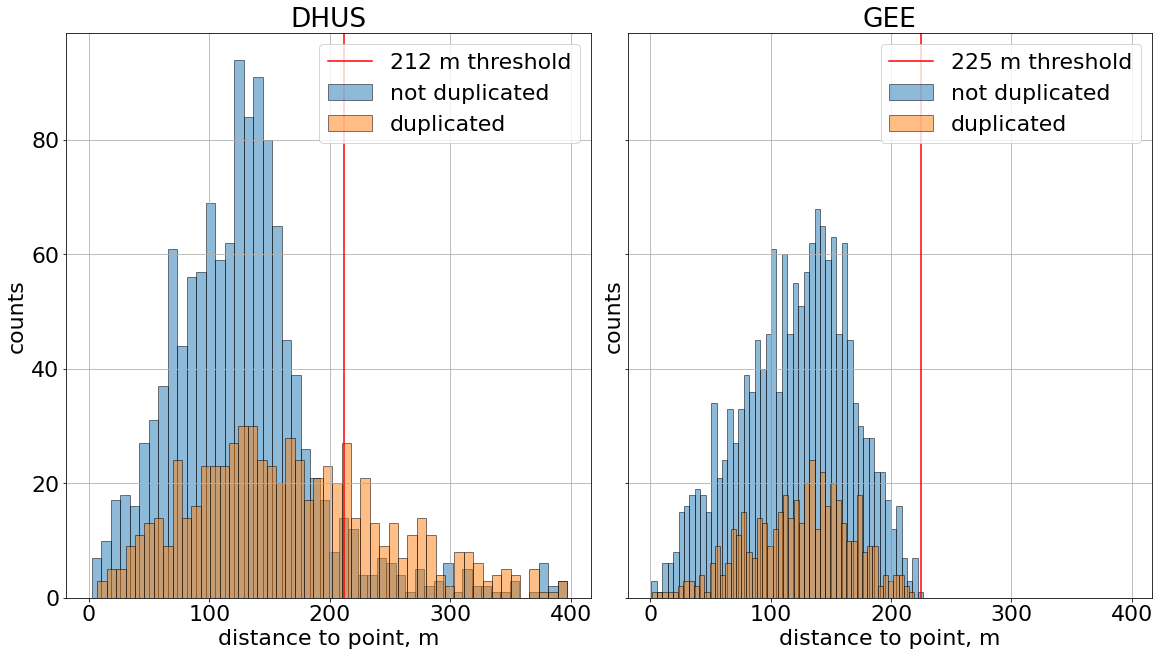

In [23]:
plt.rcParams.update({'font.size': 22})
# df_pix = df
_, axs = plt.subplots(1, 2, figsize=(16, 9), edgecolor='black', constrained_layout=True, sharey=True, sharex=True)

ax = axs[0]
df.groupby(df.quality_flags_duplicated).m_to_tower_geo.hist(ax=ax, alpha=0.5, bins=50, edgecolor='black')
# df.m_to_tower_tp.hist(ax=ax, alpha=0.5, edgecolor='black', bins=50, label='tie-point')
# df.m_to_tower_extraction.hist(ax=ax, alpha=0.5, bins=50, edgecolor='black', label='extraction coordinates')
ax.axvline(212, c='r')
ax.set_xlabel('distance to point, m')
ax.set_ylabel('counts')
ax.legend(['212 m threshold', 'not duplicated','duplicated'], loc=1)
ax.set_title('DHUS')

ax = axs[1]
gee.groupby(gee.quality_flags_duplicated).m_to_tower_geo.hist(ax=ax, alpha=0.5, bins=50, edgecolor='black')
ax.axvline(225, c='r')
ax.set_xlabel('distance to point, m')
ax.set_ylabel('counts')
ax.legend(['225 m threshold', 'not duplicated','duplicated'], loc=1)
ax.set_title('GEE')
plt.savefig('figures/fig3.png')

## Table 1
### Joining

In [24]:
# on full without any exclusions
len(df.name[df.name.isin(gee.name)]), len(df.gee_name[df.gee_name.isin(gee['system:index'])]), df.shape, gee.shape

(1152, 1888, (1909, 174), (2045, 75))

In [25]:
df.Oa01_radiance.count(), gee.Oa01_radiance.count()

(1909, 1879)

In [26]:
df = df[~df.Oa01_radiance.isna()]
gee = gee[~gee.Oa01_radiance.isna()]  # 1709 prod_ids
df.shape, gee.shape

((1909, 174), (1879, 75))

In [27]:
gee.product_id.isna().sum()

307

In [28]:
# df = df[~df.index.isin(gee.index[gee.product_id.isna()])]
gee = gee[~gee.product_id.isna()]
df.shape, gee.shape

((1909, 174), (1572, 75))

In [29]:
names_in = df.name[df.name.isin(gee.name)]
len(names_in)

1149

In [30]:
len(df.name[df.name.isin(gee.name)]), len(df.gee_name[df.gee_name.isin(gee['system:index'])]), df.shape, gee.shape

(1149, 1667, (1909, 174), (1572, 75))

Let's see for the non-matching images with full name present what is the reason

1. 211 SVL
2. 300 (211+89) NR
3. 220 ? - reprocessed

In [31]:
names_in_short = df.gee_name[~df.name.isin(gee.name) & df.gee_name.isin(gee['system:index'])]
len(names_in_short)

518

In [32]:
gee_short = gee[gee['system:index'].isin(names_in_short) & ~gee.name.isna()]# .name.values #.str.contains('NR').sum()
(~gee_short.name.str.contains('SVL') & gee_short.name.str.contains('NR')).sum(), gee_short.shape
gee_short = gee_short[~gee_short.name.str.contains('SVL') & ~gee_short.name.str.contains('NR')]
gee_short.shape
# df.reset_index().set_index('gee_name').loc[gee_short['system:index'], ['name']].to_csv(r'D:\PyCharm_projects\Spe\gee\final\dhus_full_no-match.csv')
# gee.reset_index().set_index('system:index').loc[gee_short['system:index'], ['product_id']].to_csv(r'D:\PyCharm_projects\Spe\gee\final\gee_full_no-match.csv')

(208, 75)

GEE with missing full name

In [33]:
gee[gee['system:index'].isin(names_in_short) & gee.name.isna()].shape, gee.name.isna().sum()

((0, 75), 0)

In [34]:
gee[~gee['system:index'].isin(names_in_short) & ~gee.name.isin(names_in)].name.isna().sum()

0

In [35]:
gee[~gee['system:index'].isin(names_in_short) & ~gee.name.isin(names_in)].Oa01_radiance.isna().sum()

0

## Figure 4
### Plotting rmse

In [36]:
names_in = df.name[df.name.isin(gee.name)]
len(names_in)

1149

In [37]:
names_in_short = df.gee_name[~df.name.isin(gee.name) & df.gee_name.isin(gee['system:index'])]
len(names_in_short)

518

In [38]:
bands = [x for x in gee.columns if x.startswith('Oa')]
len(bands)

21

In [39]:
df_esa = df.reset_index().set_index('name').loc[names_in]
df_gee = gee.reset_index().set_index('name').loc[names_in]
rmse_full = (df_esa[bands] - df_gee[bands]).pow(2).mean(axis=1).pow(0.5)

df_esa = df.reset_index().set_index('gee_name').loc[names_in_short]
df_gee = gee.reset_index().set_index('system:index').loc[names_in_short]
rmse_short = (df_esa[bands] - df_gee[bands]).pow(2).mean(axis=1).pow(0.5)

In [40]:
rmse_full.shape, rmse_short.shape

((1653,), (692,))

In [41]:
rmse_full.median(), (rmse_full < 2).sum(), rmse_short.median(), (rmse_short < 2).sum()

(2.3584558254437975, 733, 3.360172341074838, 288)

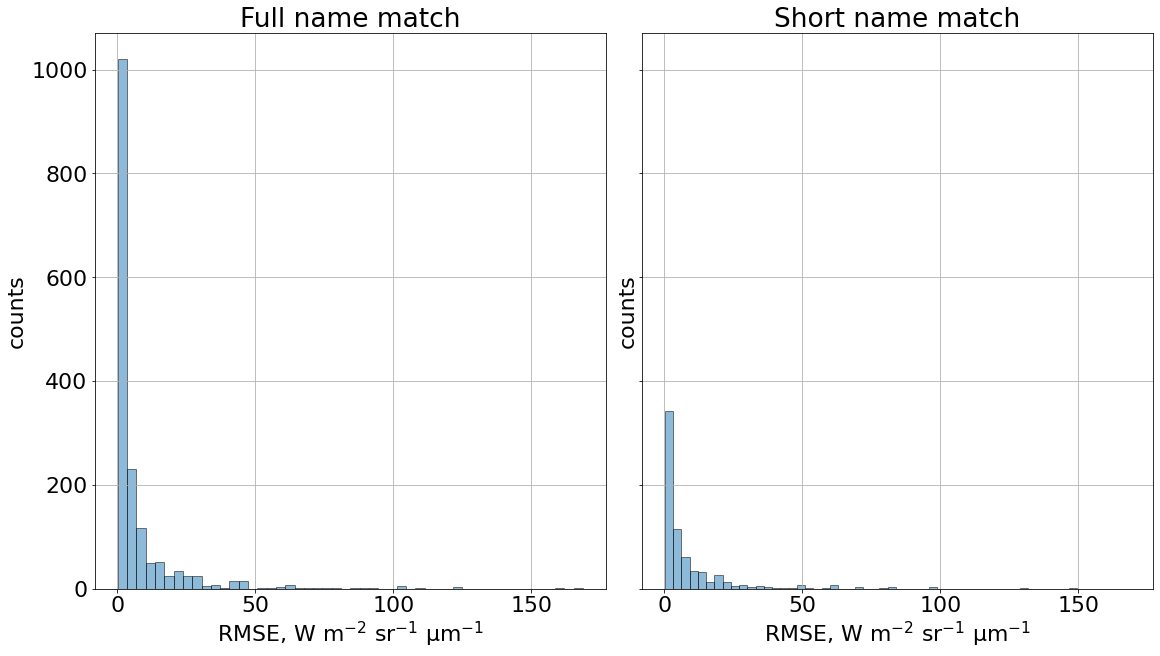

In [43]:
plt.rcParams.update({'font.size': 22})
# df_pix = df
_, axs = plt.subplots(1, 2, figsize=(16, 9), edgecolor='black', constrained_layout=True, sharey=True, sharex=True)

ax = axs[0]

rmse_full.hist(ax=ax, alpha=0.5, bins=50, edgecolor='black')
ax.set_xlabel(r'RMSE, $\rm W\ m^{-2}\ sr^{-1}\ \mu m^{-1}$')
ax.set_ylabel('counts')
ax.set_title('Full name match')

ax = axs[1]
# rmse_short[~rmse_short.index.isin(gee_short['system:index'])].hist(ax=ax, alpha=0.5, bins=50, edgecolor='black')
rmse_short.hist(ax=ax, alpha=0.5, bins=50, edgecolor='black')
ax.set_xlabel(r'RMSE, $\rm W\ m^{-2}\ sr^{-1}\ \mu m^{-1}$')  
ax.set_ylabel('counts')
ax.set_title('Short name match')
plt.savefig('figures/fig4.png')
# plt.savefig(r'D:\papers\gee_olci\proofread\figures\4_rmse_spe_cor.pdf')

## Figure 5
### Bars

Requires even more data: 1x1 and 3x3 extraction from GEE and DHUS

In [48]:
# df3x3 = join_extraction(dans_path / 'olci_extracted_3x3')
df7x7 = join_extraction(dans_path / 'extracted_olci_7x7')

0 / 25
expected 343, resulted 344
expected 1078, resulted 1079
expected 1617, resulted 1618
10 / 25
expected 637, resulted 638
20 / 25


In [49]:
#df3.join(df['gee_name']).gee_name

NameError: name 'df3' is not defined

In [50]:
gee = pd.read_csv(dans_path / 'gee.csv', index_col='dt', parse_dates=True)
gee3 = read_gee(dans_path / 's3_spe_buff500_3.csv')

df = df3x3.groupby(df3x3.index).apply(get_central).dropna()
df3 = df3x3.groupby(df3x3.index).mean()
df3 = df3.join(df['gee_name'])

In [51]:
def get_3x3_tp(df):
    df_i = df.reset_index()
    i_min = df_i.m_to_tower_tp.idxmin()
    if ~np.isnan(i_min) and (df_i.loc[i_min].m_to_tower_tp < 215):
        x_i = df_i.loc[i_min].PixelX
        y_i = df_i.loc[i_min].PixelY
        df_i['difX'] = df_i.PixelX - x_i
        df_i['difY'] = df_i.PixelY - y_i
        df_i[['difX', 'difY']]
        df_3x3 = df_i.loc[(abs(df_i.difX) <= 1) & (abs(df_i.difY) <= 1)]
        return df_3x3.set_index('dt')

In [52]:
df3x3_tp = df7x7.groupby('dt').apply(get_3x3_tp).droplevel(0)

In [53]:
df_tp = df3x3_tp.groupby(df3x3_tp.index).apply(lambda x: get_central(x, dist_col='m_to_tower_tp')).dropna()
df_tp3 = df3x3_tp.groupby(df3x3_tp.index).mean()
df_tp3 = df_tp3.join(df_tp['gee_name'])

In [54]:
df.shape, df3.shape, df_tp.shape, df_tp3.shape

((1909, 174), (2080, 168), (1594, 176), (1703, 170))

In [55]:
common = df.gee_name[df.gee_name.isin(gee['system:index'])]
common = df_tp.gee_name[df_tp.gee_name.isin(gee['system:index'])]
bands = [x for x in gee.columns if x.startswith('Oa')]
len(common),len(bands)

(1581, 21)

In [56]:
df_gee = gee.reset_index().set_index('system:index').loc[common]
df_gee3 = gee3.reset_index().set_index('system:index').loc[common]
df_esa = df.reset_index().set_index('gee_name').loc[common]
df3_esa = df3.reset_index().set_index('gee_name').loc[common]
df_tp_esa = df_tp.reset_index().set_index('gee_name').loc[common]
df_tp3_esa = df_tp3.reset_index().set_index('gee_name').loc[common]

In [57]:
df_esa.shape, df3_esa.shape, df_tp_esa.shape, df_tp3_esa.shape

((1718, 174), (1718, 168), (1647, 176), (1647, 170))

In [58]:
def get_rmse(df_esa, df_gee):
    mean = df_esa[bands].mean()
    rmse = (df_esa[bands] - df_gee[bands]).pow(2).mean(axis=0).pow(0.5)
    return rmse / mean * 100
#     return rmse

In [59]:
# rmse = (df_esa[bands] - df_gee[bands]).pow(2).mean(axis=0).pow(0.5)
# rmse3 = (df3_esa[bands] - df_gee[bands]).pow(2).mean(axis=0).pow(0.5)
# rmse_tp = (df_tp_esa[bands] - df_gee[bands]).pow(2).mean(axis=0).pow(0.5)
# rmse_tp3 = (df_tp3_esa[bands] - df_gee[bands]).pow(2).mean(axis=0).pow(0.5)

In [60]:
rmse = get_rmse(df_esa[bands], df_gee3[bands])
rmse3 = get_rmse(df3_esa[bands], df_gee3[bands])
rmse_tp = get_rmse(df_tp_esa[bands], df_gee3[bands])
rmse_tp3 = get_rmse(df_tp3_esa[bands], df_gee3[bands])
df_vs3 = pd.concat([rmse, rmse3, rmse_tp, rmse_tp3], names=['geo', 'geo 3x3', 'tp', 'tp 3x3'], axis=1)
df_vs3 = pd.concat([rmse3, rmse_tp3], names=['geo 3x3', 'tp 3x3'], axis=1)

In [61]:
rmse = get_rmse(df_esa[bands], df_gee[bands])
rmse3 = get_rmse(df3_esa[bands], df_gee[bands])
rmse_tp = get_rmse(df_tp_esa[bands], df_gee[bands])
rmse_tp3 = get_rmse(df_tp3_esa[bands], df_gee[bands])
df_vs = pd.concat([rmse, rmse3, rmse_tp, rmse_tp3], names=['geo', '3x3', 'tp', 'tp 3x3'], axis=1)
df_vs = pd.concat([rmse, rmse_tp], names=['geo', 'tp'], axis=1)

In [62]:
df_vs.index.str[:4]

Index(['Oa01', 'Oa02', 'Oa03', 'Oa04', 'Oa05', 'Oa06', 'Oa07', 'Oa08', 'Oa09',
       'Oa10', 'Oa11', 'Oa12', 'Oa13', 'Oa14', 'Oa15', 'Oa16', 'Oa17', 'Oa18',
       'Oa19', 'Oa20', 'Oa21'],
      dtype='object')

In [63]:
import matplotlib.ticker as mtick

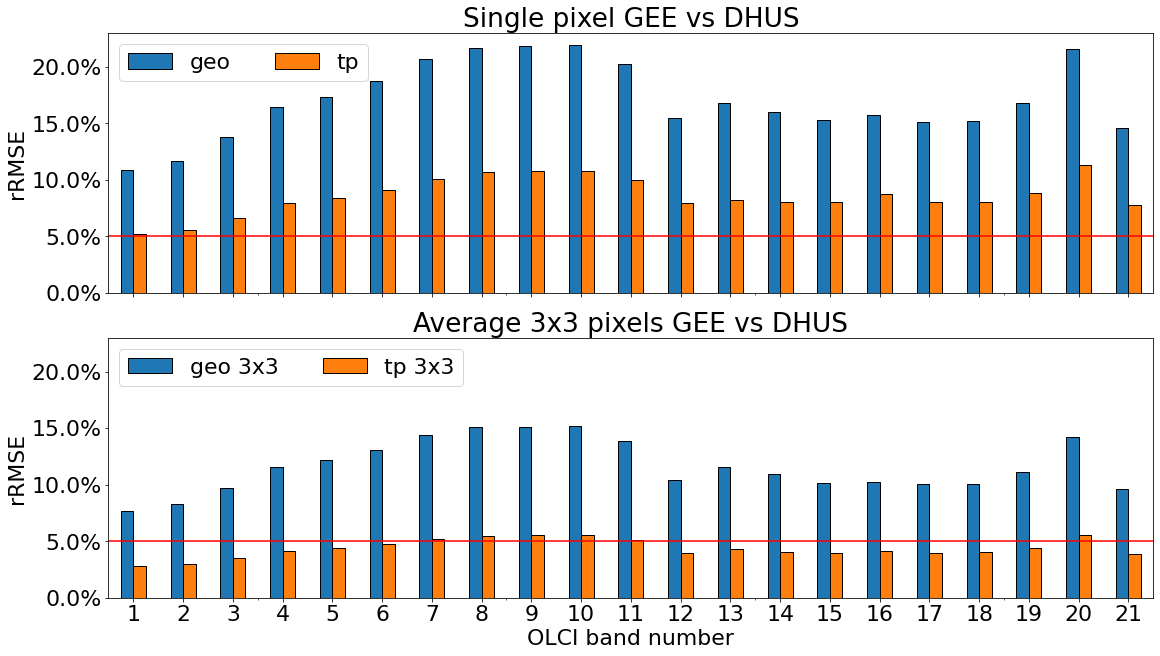

In [64]:
# df_pix = df
plt.rcParams.update({'font.size': 22})
_, axs = plt.subplots(2, 1, figsize=(16, 9), edgecolor='black', constrained_layout=True, sharey=True, sharex=True)

rot = 0  # 0
leg_loc = 2  # 1 - left, 2 - right: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html
tag = 'GEE vs DHUS'  # 'GEE'
metric = 'not'  #  'radiance', 'not'

ax = axs[0]

df_vs.plot.bar(ax=ax, legend=None, edgecolor='black')
ax.set_xlabel('OLCI band number')
if metric == 'radiance':
    ylab = r'RMSE, $W\ m^{-2}$'
    leg_loc = 1
else:
    ylab = 'rRMSE'
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel(ylab)
# ax.legend(['geo', '3x3', 'tp', 'tp 3x3'], loc='center left', bbox_to_anchor=(1, 0.5));
labels = list(range(1, 22))
ax.set_xticklabels(labels, rotation=rot)
ax.set_title(f'Single pixel {tag}')
ax.legend(['geo', 'tp'], ncol=2, loc=leg_loc)
if metric != 'radiance':
    ax.axhline(5, c='r')

ax = axs[1]
df_vs3.plot.bar(ax=ax, edgecolor='black')
ax.set_xlabel('OLCI band number')
ax.set_xticklabels(labels, rotation=rot)
ax.set_ylabel(ylab)
ax.set_title(f'Average 3x3 pixels {tag}')
ax.legend(['geo 3x3', 'tp 3x3'], ncol=2, loc=leg_loc)
if metric != 'radiance':
    ax.axhline(5, c='r')
plt.savefig('figures/fig5.png')
# ax.legend(['geo', 'geo 3x3', 'tp', 'tp 3x3'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.5));


# plt.savefig(r'D:\papers\gee_olci\figures\rrmse2.pdf')

# Augmentation

# Figure 6
## Angles

In [65]:
gee.relative_orbit_num.isna().sum()

0

In [66]:
orbits = pd.concat([gee.relative_orbit_num[gee.name.isna()].value_counts(), gee.relative_orbit_num[~gee.name.isna()].value_counts()], axis=1)
    #.dropna().astype(int).to_csv(r'D:\PyCharm_projects\Spe\gee\final\orbits.csv')

In [67]:
orbits.count(), orbits.shape

(relative_orbit_num    22
 relative_orbit_num    33
 dtype: int64,
 (33, 2))

In [68]:
orbit_n = orbits.dropna().index.values

In [69]:
df['orbit'] = df.name.str[73:76].astype(int)
# pd.concat([df.orbit.value_counts(), gee.relative_orbit_num.value_counts()], axis=1)

In [70]:
angles = df[df.orbit.isin(orbit_n)].groupby('orbit').first()[['OZA', 'OAA']]

In [71]:
gee_angles = gee.reset_index().set_index('relative_orbit_num').join(angles)[['OZA', 'OAA', 'system:index', 'name']]

Maybe google orbits are wrong

In [72]:
gee.loc[~gee.name.isna(), 'orbit_my'] = gee.loc[~gee.name.isna()].name.str[73:76].astype(int)

In [73]:
gee_angles = gee.reset_index().set_index('orbit_my').join(angles)[['OZA', 'OAA', 'system:index', 'name']]

Orbits with 1 overpass - S3B during tandem?

In [74]:
orbits_n_single = orbits[orbits.iloc[:, 1] == 1].iloc[:, 1].index
df[df.orbit.isin(orbits_n_single)].name.sort_index().values

array(['S3B_OL_1_EFR____20180517T093244_20180517T093544_20200125T214309_0180_003_164_2160_MR1_R_NT_002',
       'S3B_OL_1_EFR____20180520T100218_20180520T100518_20200125T222441_0179_003_207_1980_MR1_R_NT_002',
       'S3B_OL_1_EFR____20180521T094225_20180521T094525_20200125T223621_0179_003_221_2160_MR1_R_NT_002',
       'S3B_OL_1_EFR____20180524T101159_20180524T101459_20200125T231826_0179_003_264_1980_MR1_R_NT_002',
       'S3B_OL_1_EFR____20180525T094805_20180525T095105_20200125T233207_0179_004_264_1980_MR1_R_NT_002',
       'S3B_OL_1_EFR____20180526T092700_20180526T093000_20200125T234611_0179_004_278_2160_MR1_R_NT_002',
       'S3B_OL_1_EFR____20180526T092700_20180526T093000_20200125T234611_0179_004_278_2160_MR1_R_NT_002',
       'S3B_OL_1_EFR____20181101T103724_20181101T104024_20200115T103850_0179_016_265_1980_MR1_R_NT_002',
       'S3B_OL_1_EFR____20181105T102822_20181105T103122_20200115T112927_0179_016_322_1980_MR1_R_NT_002',
       'S3B_OL_1_EFR____20181109T101920_20181109T102220

In [75]:
common = df.gee_name[df.gee_name.isin(gee_angles['system:index'])]
# common = common[common.isin(names_in_short)]
df_angles = df.reset_index().set_index('gee_name')[['OZA', 'OAA']]
gee_angles = gee_angles.reset_index().set_index('system:index')[['OZA', 'OAA']]

In [76]:
df_angles = df_angles[~df_angles.index.duplicated()]
broken = abs(df_angles.loc[common, 'OZA'] - gee_angles.loc[common, 'OZA']) > 5

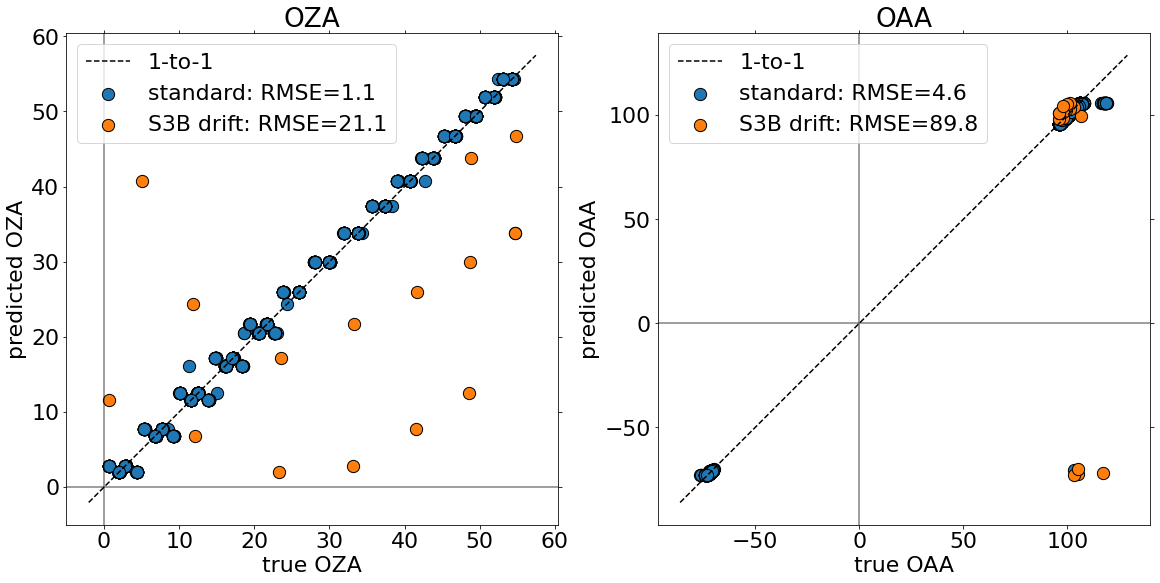

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9), constrained_layout=True)

for i, ang in enumerate(['OZA', 'OAA']):
    ax = axs[i]
    x = df_angles.loc[common, ang]
    y = gee_angles.loc[common, ang]
    
    x, y = x.align(y)

    res = dict(rmse = np.sqrt(np.mean((x[~broken] - y[~broken]) ** 2)))
    res2 = dict(rmse = np.sqrt(np.mean((x[broken] - y[broken]) ** 2)))
    
    ax.clear()
    ax.scatter(x[~broken], y[~broken], s=150, edgecolors='k')
    ax.scatter(x[broken], y[broken], s=150, edgecolors='k')
    abline(1, 0, ax)
    
    ax.legend(['1-to-1', f'standard: RMSE={round(res["rmse"], 1)}', f'S3B drift: RMSE={round(res2["rmse"], 1)}'])
    
    ax.axhline(alpha=0.5, c='k')
    ax.axvline(alpha=0.5, c='k')
    ax.set_title(ang)
    ax.set_xlabel(f'true {ang}')
    ax.set_ylabel(f'predicted {ang}')
    ax.set_aspect('equal', 'box')
plt.savefig('figures/fig6.png')

Broken orbits belong to Tandem: 2018-05 to 2018-11

In [79]:
broken[broken]

gee_name
S3B_20180515T101530_20180515T101830    True
S3B_20181026T100030_20181026T100330    True
S3B_20181027T093301_20181027T093601    True
S3B_20181029T101858_20181029T102158    True
S3B_20181030T095129_20181030T095429    True
S3B_20181031T092700_20181031T093000    True
S3B_20181102T100956_20181102T101256    True
S3B_20181103T094226_20181103T094526    True
S3B_20181106T100053_20181106T100353    True
S3B_20181107T093324_20181107T093624    True
S3B_20181110T095151_20181110T095451    True
S3B_20181111T092721_20181111T093021    True
S3B_20181111T092721_20181111T093021    True
S3B_20181113T101017_20181113T101317    True
S3B_20181114T094248_20181114T094548    True
S3B_20181118T093353_20181118T093645    True
Name: OZA, dtype: bool

## Figure 9
### Solar

In [80]:
solar_cols = [x for x in df.columns if 'solar' in x]

In [81]:
df_my = df[solar_cols].groupby(df.index.dayofyear).mean().fillna(method='backfill')
df_my.index.name = 'DOY'
# df_my.to_csv(r"D:\PyCharm_projects\s3_6s_automated\db_peiqi\TOA_radiance_incoming\toa_irradiance_my.csv")

In [82]:
gee_solar = gee.reset_index().set_index(gee.index.dayofyear).join(df_my)

In [83]:
common = df.gee_name[df.gee_name.isin(gee['system:index'])]
df_esa = df.reset_index().set_index('gee_name').loc[common]
df_gee = gee_solar.reset_index().set_index('system:index').loc[common]

In [84]:
def plot_bands(axs, col_names, df_esa, df_gee):
    for i, band in enumerate(col_names):
        print('.', end='')
        ax = axs[i]
#         res = foo.scatter_line_report(x=df_esa[band], y=df_gee[band], ax=ax, c='r', one2one=True, ms=15, alpha=1)
#         ax.clear()
        x = df_esa[band]
        y = df_gee[band]
        x, y = x.align(y)
        
        rmse = np.sqrt(np.mean((x - y) ** 2))
        ax.hexbin(x, y, mincnt=1)
#         ax.set_title(f'{band.replace("solar_flux_", "")} \n RMSE={round(res["rmse"], 1)}')
        ax.set_title(f'{band.replace("solar_flux_", "")} \n RMSE={round(rmse, 1)}')
        ax.set_aspect('equal', 'box')
        ax.xaxis.set_major_locator(plt.MaxNLocator(2))
        ax.tick_params(axis='both', which='major', labelsize=14)
#         ax.tick_params(axis='both', which='minor', labelsize=8)
        #     ax.legend(['OZA', '1-to-1'])
        #     ax.set_xlabel('DHUS')
        #     ax.set_ylabel('GEE')

.....................

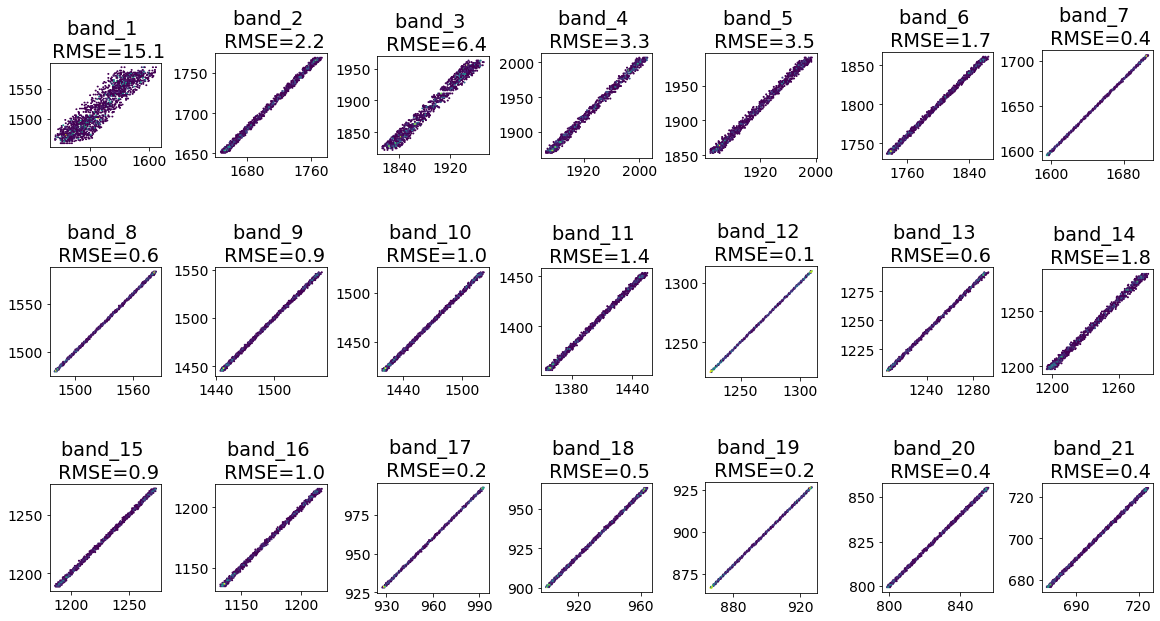

In [86]:
plt.rcParams.update({'font.size': 16})
# plt.locator_params(nbins=2)

fig, axs = plt.subplots(3, 7, figsize=(16, 9), constrained_layout=True)

axs = axs.flatten()
plot_bands(axs, solar_cols, df_esa, df_gee)
plt.savefig('figures/fig9.png')

# Appendix
## Other products

requires even more data

## Figure A1
### MODIS

from GEE - https://code.earthengine.google.com/abeda236ca3783dd532c44e2fc7c6270?noload=true

official AppEARS - https://lpdaacsvc.cr.usgs.gov/appeears

In [87]:
app_refl = pd.read_csv(dans_path / 'appendix' / 'modis_spe' / 'Spe-mod-refl-d-MCD43A4-006-results.csv', index_col='Date', parse_dates=True)
band_names_renamer = {x: x.replace('MCD43A4_006_Nadir_Reflectance_', '') for x in app_refl if 'Reflectance' in x}
app_refl = app_refl.rename(columns=band_names_renamer)

In [88]:
gee_refl = pd.read_csv(dans_path / 'appendix' / 'modis_spe' / 'MCD43A4_spe.csv')
gee_refl.index = pd.to_datetime(gee_refl['system:index'].str[:10], format='%Y_%m_%d')
band_names_renamer = {x: x.replace('Nadir_Reflectance_', '') for x in gee_refl if 'Reflectance' in x}
gee_refl = gee_refl.rename(columns=band_names_renamer)

In [89]:
gee_refl.shape, app_refl.shape

((2080, 16), (1736, 55))

In [90]:
dates_in = app_refl.index[app_refl.index.isin(gee_refl.index)]
band_names = [f'Band{i}' for i in range(1, 8)]

.......

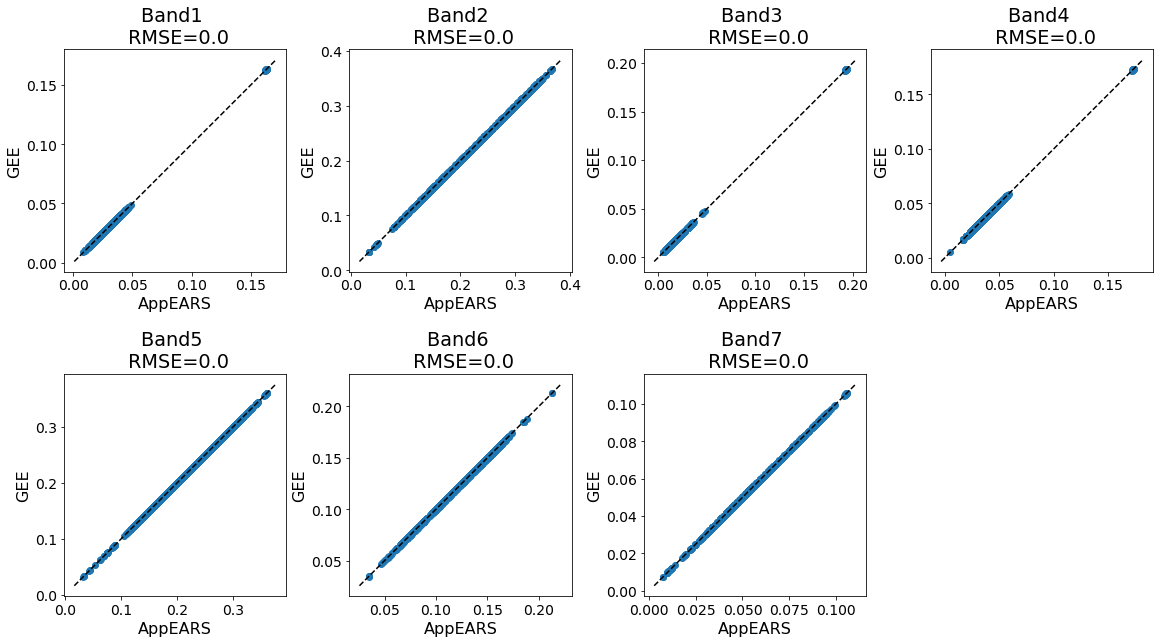

In [92]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(2, 4, figsize=(16, 9), constrained_layout=True)

axs = axs.flatten()
# plot_bands(axs, band_names, df_s2.loc[dt_in], gee_s2.loc[dt_in])

for i, band in enumerate(band_names):
    print('.', end='')
    ax = axs[i]
#         res = foo.scatter_line_report(x=df_esa[band], y=df_gee[band], ax=ax, c='r', one2one=True, ms=15, alpha=1)
#         ax.clear()
    x = app_refl.loc[dates_in, band]
    y = gee_refl.loc[dates_in, band] * 0.0001
    rmse = np.sqrt(np.mean((x - y) ** 2))
    ax.scatter(x, y)
    abline(1, 0, ax)
    ax.set_title(f'{band} \n RMSE={round(rmse, 2)}')
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('AppEARS')
    ax.set_ylabel('GEE')
    ax.tick_params(axis='both', which='major', labelsize=14)
fig.delaxes(axs[i+1])
plt.savefig('figures/a1.png')

## Figure A2
### S2

GEE - https://code.earthengine.google.com/abeda236ca3783dd532c44e2fc7c6270?noload=true

Official - https://scihub.copernicus.eu/dhus/ or with `S3_loader`


In [93]:
def read_snap(pixels, products):
    df_pix = pd.read_csv(pixels, comment='#', sep='\t', index_col='ProdID')
    df_prod = pd.read_csv(products, comment='#', sep='\t', index_col='ProductID')
    df_prod['name'] = df_prod.ProductLocation.apply(lambda x: Path(x).with_suffix('').name)
    return df_pix.join(df_prod)

In [94]:
path = Path(dans_path / 'appendix' / 's2_gezira')
df_s2 = read_snap(path / 'PWA_20m_CF-1.4_measurements.txt', path / 'PWA_20m_productIdMap.txt')
df_s2.index = pd.to_datetime(df_s2['Date(yyyy-MM-dd)'] + ' ' + df_s2['Time(HH_mm_ss)'])
df_s2.shape

(71, 31)

In [95]:
gee_s2 = pd.read_csv(path / "gezira20m.csv")  # gezira20m.csv  gezira_s2.csv
gee_s2 = gee_s2[gee_s2['system:index'].str.contains('PWA')]  # the point also captured PWB
gee_s2.index = pd.to_datetime(gee_s2['system:index'].str[:15])
gee_s2.shape

(54, 25)

In [96]:
band_names = df_s2.columns[df_s2.columns.str.startswith('B')]
band_names

Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11',
       'B12'],
      dtype='object')

In [97]:
dt_in = df_s2.index[df_s2.index.isin(gee_s2.index)]

............

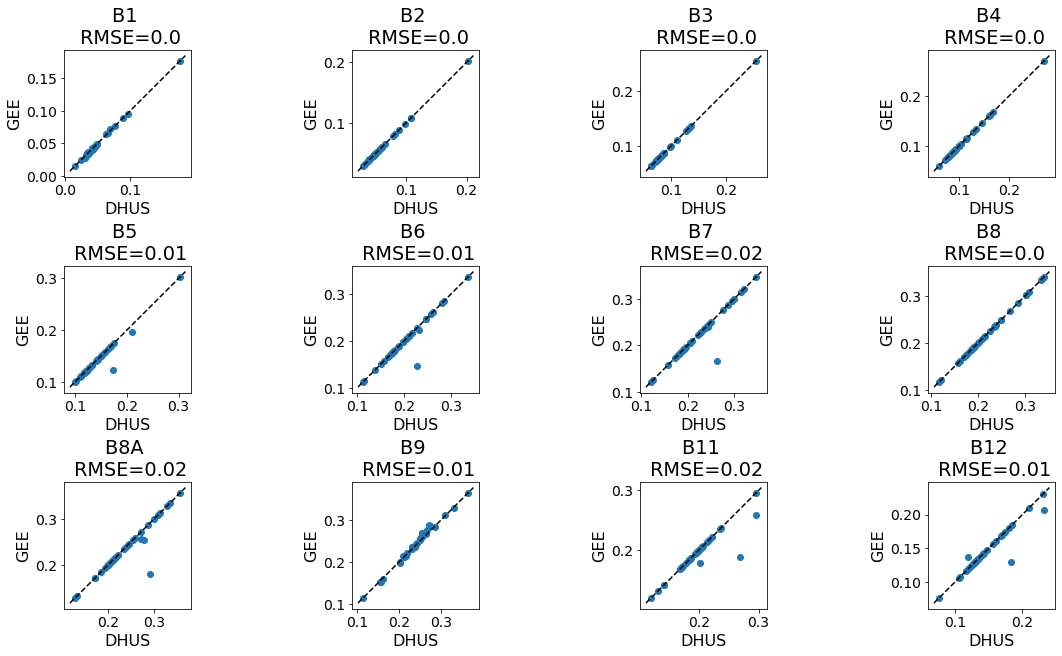

In [99]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(3, 4, figsize=(16, 9), constrained_layout=True)

axs = axs.flatten()
# plot_bands(axs, band_names, df_s2.loc[dt_in], gee_s2.loc[dt_in])

for i, band in enumerate(band_names):
    print('.', end='')
    ax = axs[i]
#         res = foo.scatter_line_report(x=df_esa[band], y=df_gee[band], ax=ax, c='r', one2one=True, ms=15, alpha=1)
#         ax.clear()
    x = df_s2.loc[dt_in, band]
    x[x==0] = np.nan
    y = gee_s2.loc[dt_in, band]
    rmse = np.sqrt(np.mean((x - y) ** 2))
    ax.scatter(x, y)
    abline(1, 0, ax)
    ax.set_title(f'{band} \n RMSE={round(rmse, 2)}')
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('DHUS')
    ax.set_ylabel('GEE')
    ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('figures/a2.png')  